Solving the 2D, linearized SWE (dimensionless) gravity wave subsystem:
\begin{align*}
\partial_t u &= -c\ \partial_x h \\
\partial_t v &= -c\ \partial_y h \\
\partial_t h &= -c\ \left( \partial_x u + \partial_y v \right) \,,
\end{align*}
where $ c $ is the wave propigation speed, 
$ u $ is the fluid velocity in the $ x $-direction,
$ v $ is the fluid velocity in the $ y $-direction,
and $ h $ is the fluid layer thickness.
Note that all qauntities are dimensionless.

Assuming the appropriate smoothness, we can write the above as the wave equation in 2D:
$$ \partial_t^2 h = c^2\ \Delta h \,. $$

For simplicity, we will solve this system with a centered finite difference discretization in space and a Runge-Kutta time-discretization.
The domain is a simple rectangular, cartesian grid.
Finally, we assume no-flow boundary conditions (i.e. zero boundary conditions).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# parameters
c = 1  # wave propigation speed

xmin = 0
xmax = 2

ymin = -1
ymax = 1

dx = 0.05
dy = 0.05


# setup uniform cartesian grid
xgrid = np.arange(xmin, xmax+dx, dx)
ygrid = np.arange(ymin, ymax+dy, dy)

x, y = np.meshgrid(xgrid, ygrid)

N = len(xgrid)
M = len(ygrid)

We treat each state variable as an $ MN \times 1 $ vector, where $ N $ and $ M $ are the number of $ x $ and $ y $-discretization points respectivly.

Then, we can implement our centered finite differences as a matrix-vector multiplies.

In [ ]:
# create the state variable(s)
# make a 2 X 3 X M*N array, where 
# indexes along the first axis are time levels
# indexes along the second axis are 
#     0: u
#     1: v
#     2: h
# Along the third axis, we can index as [:, N*i + j] to get 
# the 'i-jth entry' in the variable 'matrix'
state = np.zeros([2, 3, M*N])


# build the RHS operators as M*N X M*N matricies
Dx = np.zeros([M*N, M*N])
Dy = np.zeros([M*N, M*N])

for i in range(1, M-1):
    for j in range(1, N-1):
        Dx[N*i + j, N*i + (j-1)] = -1
        Dx[N*i + j, N*i + (j+1)] = 1
        
        Dy[N*i + j, N*(i-1) + j] = -1 
        Dy[N*i + j, N*(i+1) + j] = 1
    # END for
# END for

Dx = Dx / (2*dx)
Dy = Dy / (2*dy)


#  matrix operator tendency routine
def rhs(state):
    rhs = np.zeros([3, M*N])

    rhs[0] = -c * Dx @ state[2, :]
    rhs[1] = -c * Dy @ state[2, :]
    rhs[2] = -c * ( Dx @ state[0, :] + 
                    Dy @ state[1, :] )

    return rhs
# END rhs()


# RK4
def RK4step(state):
    s1 = rhs(state)

    s2 = rhs( state + (dt/2)*s1 )

    s3 = rhs( state + (dt/2)*s2 )

    s4 = rhs( state + dt*s3 )

    return ( state + (dt/6)*( s1 + 2*s2 + 2*s3 + s4 ) )
# END RK4step()

We set the initial condition as a Gaussian bump of a given height centered in the domain, then begin time-stepping with RK4.

In [64]:
# initial condition
gBumpHeight = 0.1
gBump = gBumpHeight * np.exp( -25*( (x - (xmax+xmin)/2)**2 + (y - (ymax+ymin)/2)**2 ) )

state[0, 2, :] = gBump.reshape([M*N])

# time-stepping
dt = 0.01
nsteps = 70

for step in range(0, nsteps):
    state[(step+1)%2, :, :] = RK4step(state[step%2, :, :])
# END for

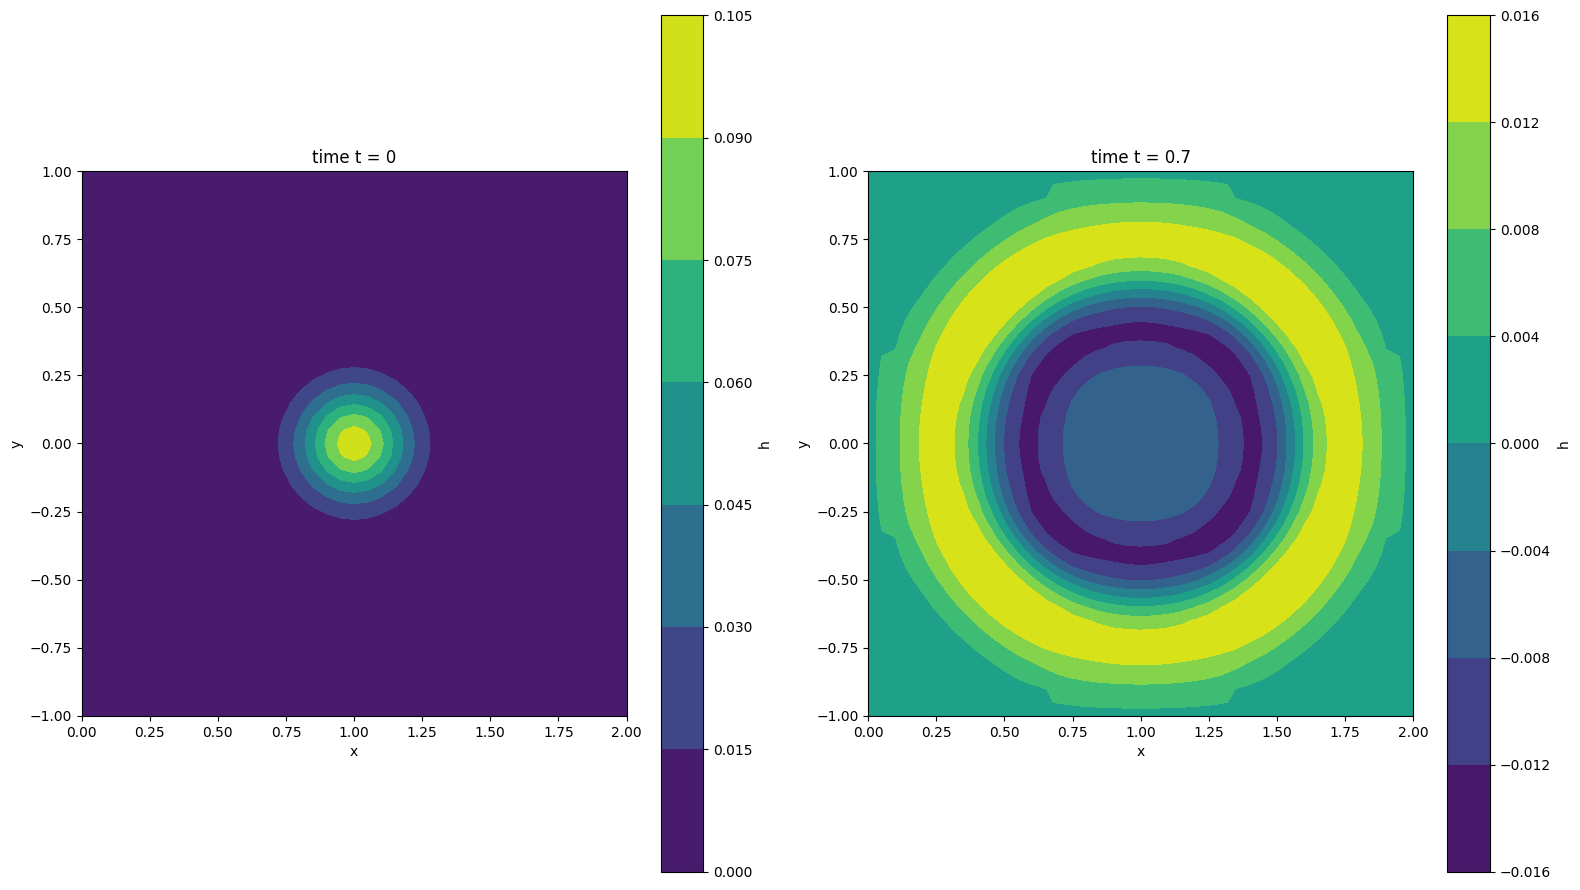

In [91]:
# visualization
h = state[nsteps%2, 2, :].reshape([M, N])

fig, axes = plt.subplots(1, 2, figsize=[16,9])

csInitial = axes[0].contourf(x, y, gBump)
csFinal = axes[1].contourf(x, y, h)

axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_aspect('equal')
axes[0].set_title('time t = 0')

axes[1].set_xlim(xmin, xmax)
axes[1].set_ylim(ymin, ymax)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_aspect('equal')
axes[1].set_title('time t = {:.2}'.format(dt*nsteps))

cbarInitial = fig.colorbar(csInitial)
cbarInitial.set_label('h')

cbarFinal = fig.colorbar(csFinal)
cbarFinal.set_label('h')

fig.tight_layout()
plt.show()